# 프로젝트: ResNet Ablation Study

--------------------------

ResNet은 skip connection을 활용해 신경망이 수렴이 잘 되도록 하여 층을 깊게 쌓아 정확도를 높인 모델

## ✅ 실습 목표  

--------------

* 직접 ResNet 구현하기
* 모델을 config에 따라서 변경 가능하도록 만들기
* 직접 실험해서 성능 비교하기

## ✅ 목차

---------------------------
#### 1. 데이터 준비하기    

#### 2. Input Normalization    

#### 3. ResNet 기본 블록 구성하기     

#### 4. ResNet-34, ResNet-50 Complete Model    

#### 5. 일반 네트워크(plain network) 만들기    

#### 6. 모델별 학습    

#### 7. 모델 학습 결과 비교    

#### 8. 시각화 해보기

-----------------------------------------

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어있는지 확인해보겠습니다!
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 준비하기

------------------------
tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 사용하겠습니다.

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)


In [4]:
# Tensorflow 데이터셋을 로드했으니 feature정보를 확인해보도록 하겠습니다!
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해봅시다!
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


🔼 tensorflow데이터셋은 numpy가 아니라서 ds_train.shape가 존재하지 않음

## 2. Input Normalization

----------------------------------

* 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

2

🔽 각 코드로 클래스가 어떻게 구성되어있는지, 어떤 이미지가 있는지 확인해보도록 하겠습니다

In [9]:
ds_info.features["label"].names

['cat', 'dog']

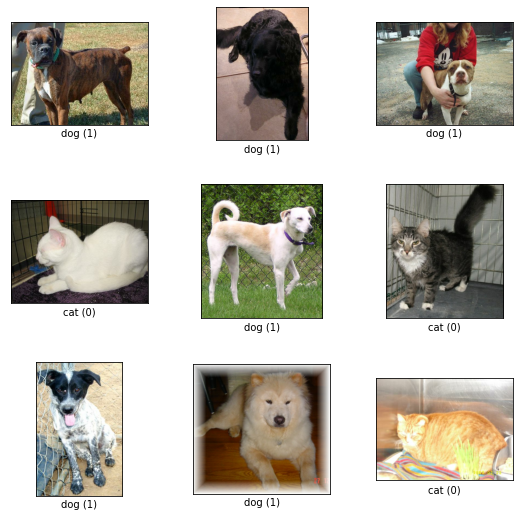

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

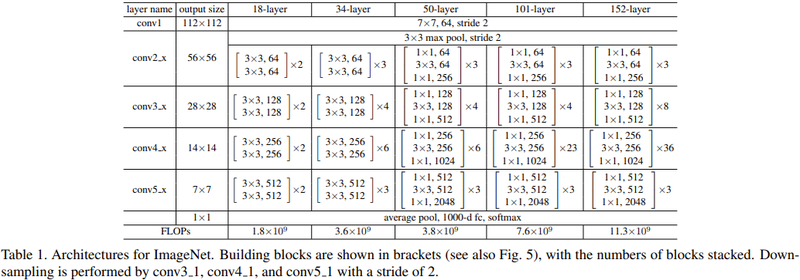

* ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태
* ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됨

## 3. ResNet 기본 블록 구성하기

In [11]:
def conv_block(
    input_layer, 
    channel, 
    kernel_size, 
    strides=1, 
    activation='relu'):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(1e-4),
        padding='same',
        strides=strides
        )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [12]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [13]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## 4. ResNet-34, ResNet-50 Complete Model

### ResNet-34

In [14]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

### ResNet-50

In [15]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

## 5. 일반 네트워크(plain network) 만들기

In [16]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [17]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### Plain-34

In [18]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

### Plain-50

In [19]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

In [20]:
del resnet_34
del resnet_50
del plain_34
del plain_50

## 6. 모델별 학습  

-----------------------

* ResNet-34
* ResNet-50
* Plain-34
* Plain-50

In [21]:
BATCH_SIZE = 16
EPOCH = 10

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

* ### ResNet-34

In [22]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 305s 246ms/step - loss: 2.2604 - accuracy: 0.5757 - val_loss: 1.9015 - val_accuracy: 0.5593
Epoch 2/10
1163/1163 [==============================] - 292s 251ms/step - loss: 1.1653 - accuracy: 0.6113 - val_loss: 0.9598 - val_accuracy: 0.6305
Epoch 3/10
1163/1163 [==============================] - 282s 243ms/step - loss: 0.8111 - accuracy: 0.6794 - val_loss: 9.8442 - val_accuracy: 0.5272
Epoch 4/10
1163/1163 [==============================] - 282s 243ms/step - loss: 0.6919 - accuracy: 0.7208 - val_loss: 0.6416 - val_accuracy: 0.7371
Epoch 5/10
1163/1163 [==============================] - 283s 243ms/step - loss: 0.6384 - accuracy: 0.7408 - val_loss: 1.2859 - val_accuracy: 0.5597
Epoch 6/10
1163/1163 [==============================] - 282s 242ms/step - loss: 0.6183 - accuracy: 0.7609 - val_loss: 0.8874 - val_accuracy: 0.5684
Epoch 7/10
1163/1163 [==============================] - 282s 243ms/step - loss: 0.5669 - accuracy: 0.7917 - val_

🔽 따로 dataframe으로 만들어서 csv파일로 지정해 놓은 경로에 저장 후 나중에 결과비교할 때 사용하도록 하겠습니다.

In [27]:
import pandas as pd
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('/aiffel/aiffel/going_deeper/ResNet/data/history_resnet_34.csv', index=False)

* ### ResNet-50

In [28]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/10
1163/1163 [==============================] - 292s 220ms/step - loss: 5.1587 - accuracy: 0.5899 - val_loss: 2.6096 - val_accuracy: 0.5766
Epoch 2/10
1163/1163 [==============================] - 220s 189ms/step - loss: 2.0802 - accuracy: 0.6504 - val_loss: 1.4385 - val_accuracy: 0.5958
Epoch 3/10
1163/1163 [==============================] - 220s 190ms/step - loss: 1.3345 - accuracy: 0.6226 - val_loss: 1.0899 - val_accuracy: 0.6213
Epoch 4/10
1163/1163 [==============================] - 220s 189ms/step - loss: 1.0094 - accuracy: 0.6716 - val_loss: 1.0259 - val_accuracy: 0.5777
Epoch 5/10
1163/1163 [==============================] - 220s 189ms/step - loss: 0.8331 - accuracy: 0.7177 - val_loss: 1.4076 - val_accuracy: 0.5608
Epoch 6/10
1163/1163 [==============================] - 220s 189ms/step - loss: 0.7225 - accuracy: 0.7566 - val_loss: 0.7004 - val_accuracy: 0.7619
Epoch 7/10
1163/1163 [==============================] - 220s 190ms/step - loss: 0.6777 - accuracy: 0.7681 - val_

🔽 따로 dataframe으로 만들어서 csv파일로 지정해 놓은 경로에 저장 후 나중에 결과비교할 때 사용하도록 하겠습니다.

In [29]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })
df_resnet_50.to_csv('/aiffel/aiffel/going_deeper/ResNet/data/history_resnet_50.csv', index=False)

* ### Plain-34

In [30]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 276s 232ms/step - loss: 1.9491 - accuracy: 0.5192 - val_loss: 1.2686 - val_accuracy: 0.5507
Epoch 2/10
1163/1163 [==============================] - 270s 232ms/step - loss: 1.1712 - accuracy: 0.5363 - val_loss: 1.0015 - val_accuracy: 0.5149
Epoch 3/10
1163/1163 [==============================] - 270s 232ms/step - loss: 0.9972 - accuracy: 0.5154 - val_loss: 0.9170 - val_accuracy: 0.5222
Epoch 4/10
1163/1163 [==============================] - 270s 232ms/step - loss: 0.8989 - accuracy: 0.5066 - val_loss: 0.8391 - val_accuracy: 0.5132
Epoch 5/10
1163/1163 [==============================] - 270s 232ms/step - loss: 0.8411 - accuracy: 0.5057 - val_loss: 8.2906 - val_accuracy: 0.5101
Epoch 6/10
1163/1163 [==============================] - 269s 232ms/step - loss: 0.8121 - accuracy: 0.5093 - val_loss: 35.4810 - val_accuracy: 0.4914
Epoch 7/10
1163/1163 [==============================] - 270s 232ms/step - loss: 0.7904 - accuracy: 0.5154 - val

🔽 따로 dataframe으로 만들어서 csv파일로 지정해 놓은 경로에 저장 후 나중에 결과비교할 때 사용하도록 하겠습니다.

In [31]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('/aiffel/aiffel/going_deeper/ResNet/data/history_plain_34.csv', index=False)

* ### Plain-50

In [32]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 453s 369ms/step - loss: 4.0409 - accuracy: 0.5270 - val_loss: 2.0987 - val_accuracy: 0.5214
Epoch 2/10
1163/1163 [==============================] - 406s 349ms/step - loss: 1.9309 - accuracy: 0.5400 - val_loss: 1.5285 - val_accuracy: 0.5157
Epoch 3/10
1163/1163 [==============================] - 406s 349ms/step - loss: 1.4636 - accuracy: 0.5011 - val_loss: 1.2756 - val_accuracy: 0.4896
Epoch 4/10
1163/1163 [==============================] - 406s 349ms/step - loss: 1.2756 - accuracy: 0.5494 - val_loss: 1.1921 - val_accuracy: 0.4853
Epoch 5/10
1163/1163 [==============================] - 406s 349ms/step - loss: 1.2068 - accuracy: 0.5123 - val_loss: 1.0455 - val_accuracy: 0.4756
Epoch 6/10
1163/1163 [==============================] - 405s 348ms/step - loss: 1.0254 - accuracy: 0.5121 - val_loss: 0.9190 - val_accuracy: 0.4851
Epoch 7/10
1163/1163 [==============================] - 406s 349ms/step - loss: 0.9257 - accuracy: 0.5031 - val_

🔽 따로 dataframe으로 만들어서 csv파일로 지정해 놓은 경로에 저장 후 나중에 결과비교할 때 사용하도록 하겠습니다.

In [33]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('/aiffel/aiffel/going_deeper/ResNet/data/history_plain_50.csv', index=False)

## 7. 모델 학습 결과 비교

In [34]:
history_resnet_34 = pd.read_csv('/aiffel/aiffel/going_deeper/ResNet/data/history_resnet_34.csv')
history_resnet_50 = pd.read_csv('/aiffel/aiffel/going_deeper/ResNet/data/history_resnet_50.csv')
history_plain_34 = pd.read_csv('/aiffel/aiffel/going_deeper/ResNet/data/history_plain_34.csv')
history_plain_50 = pd.read_csv('/aiffel/aiffel/going_deeper/ResNet/data/history_plain_50.csv')

## 8. 시각화 해보기   

--------------

* ResNet-34 vs Plain-34 비교
* 전체적으로 비교하기

### ResNet-34 vs Plain-34 비교

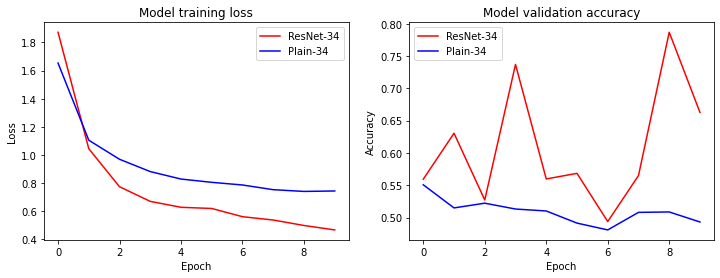

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

### 전체적으로 비교하기

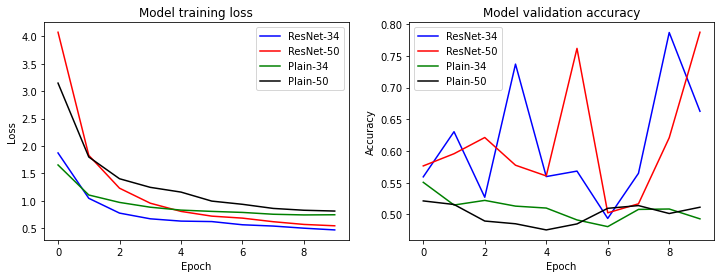

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'g')
plt.plot(history_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'g')
plt.plot(history_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

|Model|Loss|Acc|
|:----:|:----:|:----:|
|ResNet-34|0.4890|**0.6627**|
|Plain-34|0.7494|0.4931|
|ResNet-50|0.5556|**0.7873**|
|Plain-50|0.8310|0.5114|

* 표를 보면 알 수 있듯이 skip connection이 없는 plain network보다 ResNet의 정확도가 높게 나왔고 skip connection 존재의 유무에 따라서 영향을 준다는 것을 알 수 있다.
* 그리고 레이어가 깊은 ResNet-50이 ResNet-34보다 정확도가 높게 나온 것을 알 수 있다.

# 🌟 루브릭

|평가문항|상세기준|
|:---------|:----------|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

# 🌟 회고

* 논문을 읽고 구현하는 것이 쉽지 않음을 깨닫는 노드였던 것 같다.
* 논문읽는 연습도 더 하고 익숙해져야겠다.

# 🌟 참고

* [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)
* [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
* [논문리뷰 참고1](https://jxnjxn.tistory.com/22)
* [논문리뷰 참고2](https://m.blog.naver.com/laonple/220793640991)
* [진영님 깃허브](https://github.com/JYnote/AIFFEL_INCHEON/blob/main/GOING_DEEPER/Going_Deeper_01/ResNet.ipynb)
* [우용님 깃허브](https://github.com/dldndyd01/AI_STUDY/blob/master/Ablation%20Study/ResNet.ipynb)